In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
# SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

# Path to Nuclei trained weights
NUCLEI_MODEL_PATH = os.path.join(MODEL_DIR, 'nuclei20180227T1243', "mask_rcnn_nuclei_0486.h5")

## Configurations

In [4]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import nuclei
config = nuclei.NucleiConfig()
NUCLEI_DIR = "../../input"
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               400
MEAN_PIXEL                     [44.57284587, 40.71265898, 48.6901747]
MINI_MASK_SHAPE                (28, 28)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_N

In [5]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()

## Notebook Preferences

In [7]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "training"

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [9]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "minival")
elif config.NAME == "nuclei":
    dataset = nuclei.NucleiDataset()
    dataset.load_nuclei(NUCLEI_DIR, "train")
    dataset.prepare()
    
    dataset_train, dataset_val = dataset.extract_train_val()
    dataset_train.prepare()
    dataset_val.prepare()

# Must call before using the dataset
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 34
Classes: ['BG', 'nu']


## Load Model

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode=TEST_MODE, model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
elif config.NAME == "nuclei":
    weights_path = NUCLEI_MODEL_PATH

# Or, uncomment to load the last model you trained
weights_path = model.find_last()[1]
# model.load_weights = load_weights
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /Users/ralphtigoumo/Documents/kaggle/nuclei/solutions/kmrcnn/logs/nuclei20180227T1243/mask_rcnn_nuclei_0486.h5


## Run Detection

In [9]:
image_id = 8
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
molded_images, image_metas, windows = model.mold_inputs([image])
detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, \
            rois, rpn_class, rpn_bbox =\
            model.keras_model.predict([molded_images, image_metas], verbose=0)

In [10]:
log("detections", detections)

detections               shape: (1, 100, 6)           min:    0.00000  max:  805.00000


image ID: nuclei.07761fa39f60dc37022dbbe8d8694595fd5b77ceb2af2a2724768c8e524d6770 (8) 
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  233.00000
molded_images            shape: (1, 1024, 1024, 3)    min:  -48.69017  max:  192.28734
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


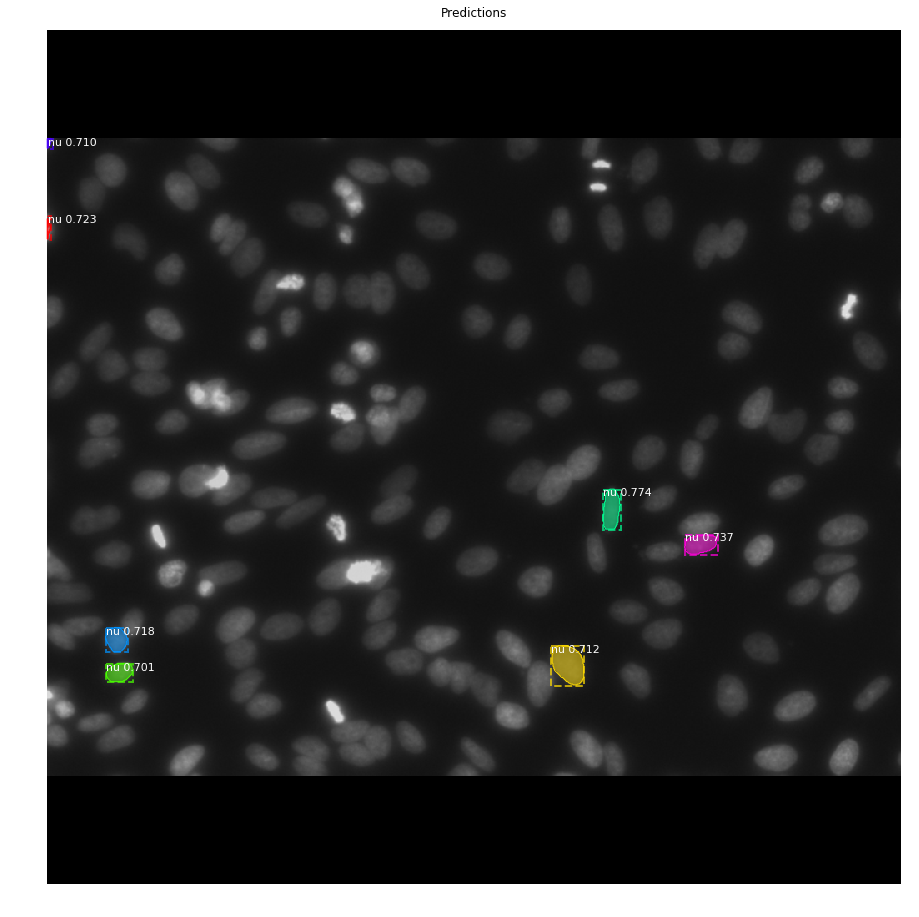

gt_class_id              shape: (183,)                min:    1.00000  max:    1.00000
gt_bbox                  shape: (183, 4)              min:    0.00000  max: 1023.00000
gt_mask                  shape: (1024, 1024, 183)     min:    0.00000  max:  255.00000


In [11]:
# image_id = random.choice(dataset_val.image_ids)
image_id = 8
# image_id = 34940
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# # Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [9]:
pred_mask, ground_mask = utils.resh_to_orig(r['masks'], image_meta, dataset=dataset_val)

In [10]:
log('pred_mask', pred_mask)
log('ground_mask', ground_mask)

pred_mask                shape: (520, 696, 7)         min:    0.00000  max:    1.00000
ground_mask              shape: (520, 696, 183)       min:    0.00000  max:    1.00000


In [11]:
print(utils.iou_metric(ground_mask,pred_mask))

0.030565926378470925


In [79]:
print(r.keys())

dict_keys(['rois', 'class_ids', 'scores', 'masks'])


In [13]:
image_ids = dataset_val.image_ids
APs = []
print(image_ids.shape)
program_starts = time.time()
for image_id in image_ids:
    print("Working on id: {}".format(image_id))
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    # molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    # AP, precisions, recalls, overlaps =\
        # utils.compute_ap(gt_bbox, gt_class_id,
                         # r["rois"], r["class_ids"], r["scores"])
    pred_mask, ground_mask = utils.resh_to_orig(r['masks'], image_meta, dataset=dataset_val)
    AP = utils.iou_metric(ground_mask,pred_mask)
    if AP < 0.5:
        print(image_id)
        print(AP)
    # print(AP)
    APs.append(AP)
print("It has been {0} minutes since the loop started".format((time.time() - program_starts)/60))
print("mAP: ", np.mean(APs))


(34,)
8
0.13575666043805742
21
0.43969543828582813
30
0.37195003840341057
31
0.3091399181608444
It has been 2.1584977984428404 minutes since the loop started
mAP:  0.7671259060946839


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [12]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -6.63701  max:    3.31456
positive_anchors         shape: (128, 4)              min:   -8.00000  max: 1025.65685
negative_anchors         shape: (128, 4)              min:   -5.65685  max: 1038.62742
neutral anchors          shape: (261632, 4)           min: -181.01934  max: 1141.01934
refined_anchors          shape: (128, 4)              min:    0.00000  max: 1023.00000


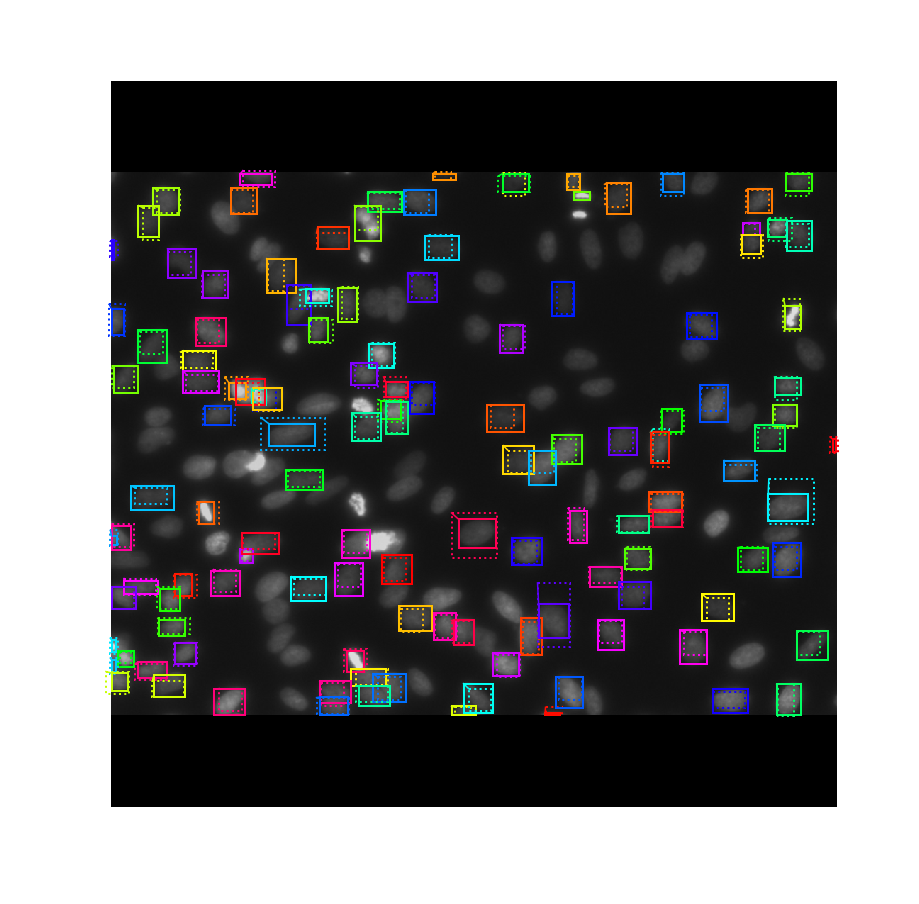

In [14]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [39]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    print("nms_node is None")
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output)
])

nms_node is None
rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min:  -45.25483  max: 1053.25488
refined_anchors          shape: (1, 6000, 4)          min:  -46.25485  max: 1037.61975
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max: 1024.00000
post_nms_anchor_ix       shape: (880,)                min:    0.00000  max: 5990.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
rpn_rois                 shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


In [17]:
model.anchors.shape

(261888, 4)

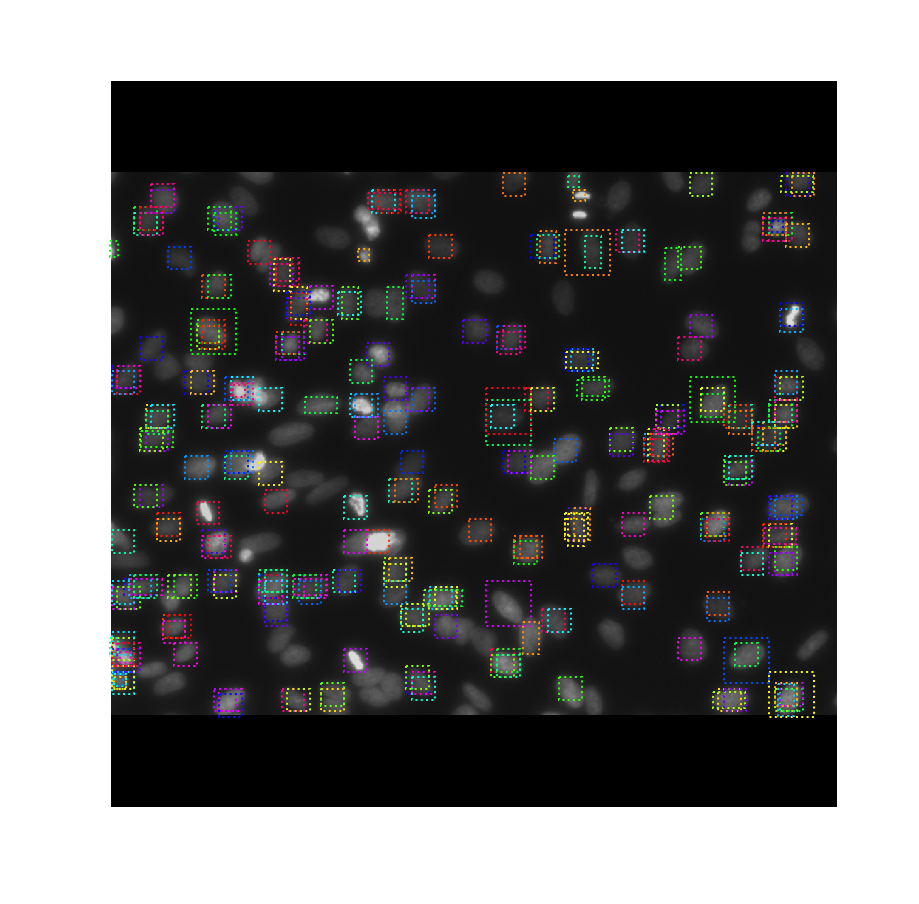

In [32]:
# Show top anchors by score (before refinement)
limit = 300
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

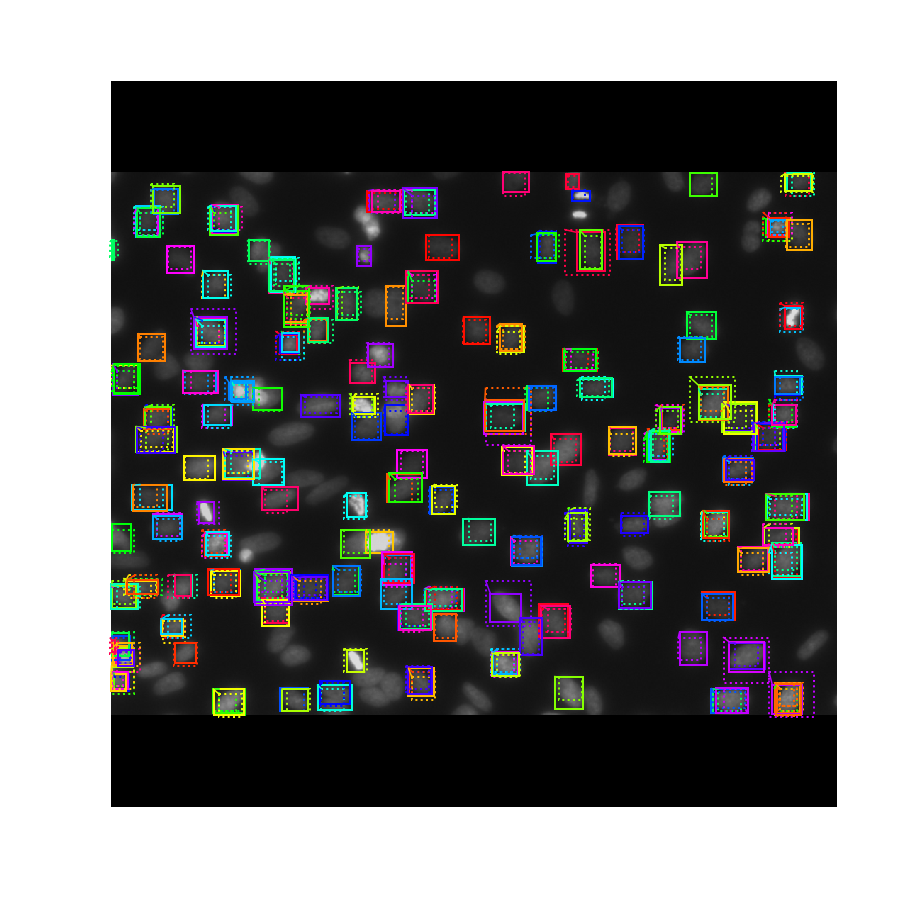

In [34]:
# Show top anchors with refinment. Then with clipping to image boundaries
limit = 300
# ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=get_ax())
# visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

(200,)


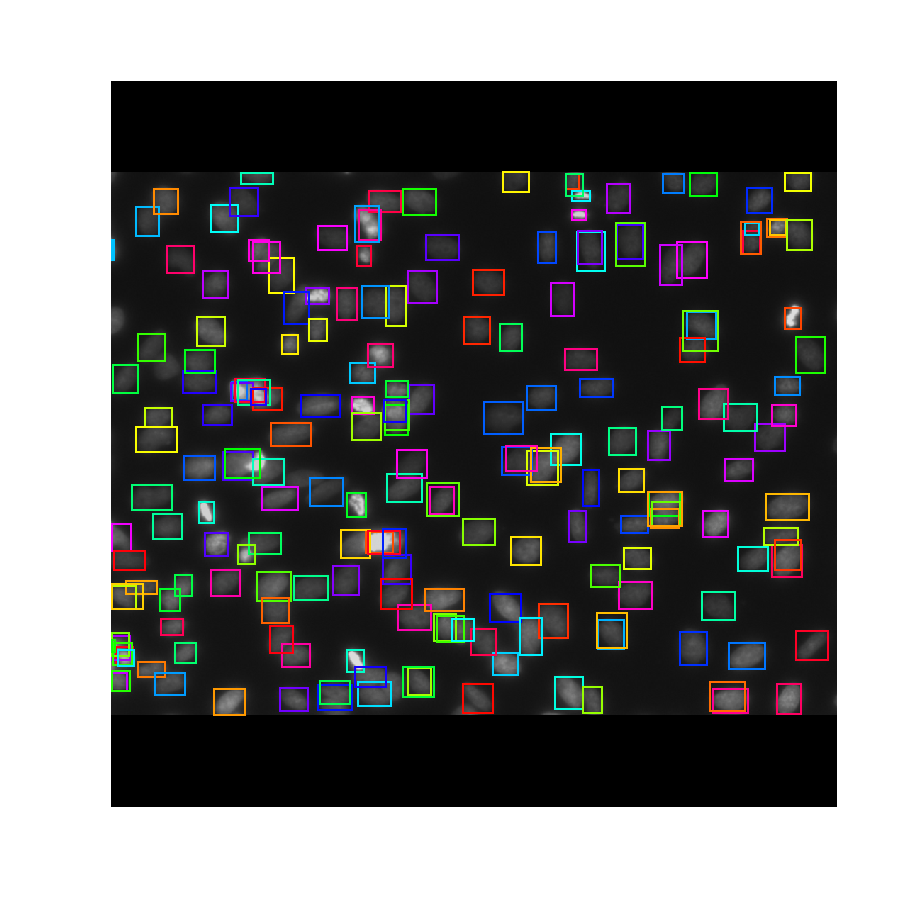

In [46]:
# Show refined anchors after non-max suppression
limit = 200
ixs = rpn["post_nms_anchor_ix"][:limit]
print(ixs.shape)
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

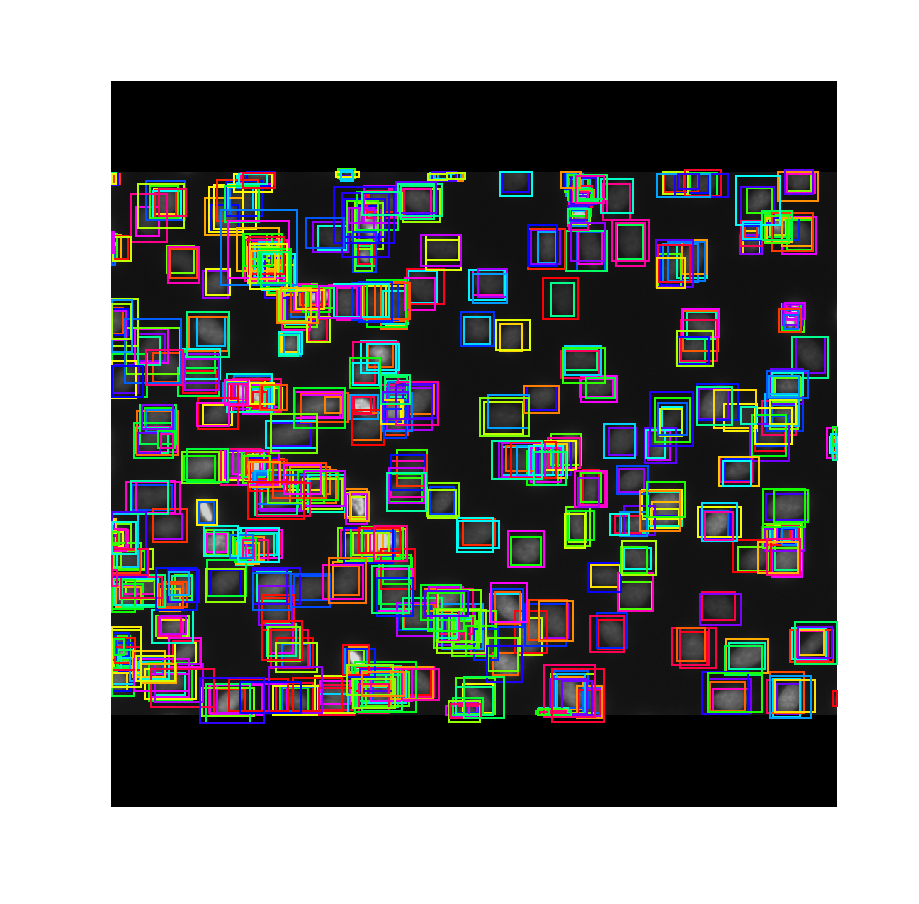

In [56]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 1000
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [57]:
proposals.shape

(1000, 4)

In [97]:
from IPython.core.debugger import set_trace
def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.

    Note: the areas are passed in rather than calculated here for
          efficency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def compute_overlaps(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].

    For better performance, pass the largest set first and the smaller second.
    """
    # Areas of anchors and GT boxes
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Compute overlaps to generate matrix [boxes1 count, boxes2 count]
    # Each cell contains the IoU value.
    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps


def compute_recall(pred_boxes, gt_boxes, iou):
    """Compute the recall at the given IoU threshold. It's an indication
    of how many GT boxes were found by the given prediction boxes.

    pred_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    gt_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    """
    # Measure overlaps
    overlaps = compute_overlaps(pred_boxes, gt_boxes)
    set_trace()
    iou_max = np.max(overlaps, axis=1)
    iou_argmax = np.argmax(overlaps, axis=1)
    positive_ids = np.where(iou_max >= iou)[0]
    matched_gt_boxes = iou_argmax[positive_ids]

    recall = len(set(matched_gt_boxes)) / gt_boxes.shape[0]
    return recall, positive_ids


In [99]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (261888)       Recall: 0.290  Positive anchors: 64
Refined Anchors ( 6000)   Recall: 1.000  Positive anchors: 3434
Post NMS Anchors ( 1000)  Recall: 1.000  Positive anchors: 254


In [91]:
model.anchors.shape

(261888, 4)

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [103]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    # ("proposal_targets", model.keras_model.get_layer("proposal_targets").output)
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 2, 4)       min:   -4.46033  max:    4.09935
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000
detections               shape: (1, 100, 6)           min:    0.00000  max:  805.00000
